In [31]:
import numpy as np
import pandas as pd
import time
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Utilizando um dataset compreendendo apenas o primeiro trimestre de 2022 apenas para exemplificar o projeto, o projeto real utilizou dados de 3 anos

In [3]:
df = pd.read_csv(r'API\datasets\base_01012022_31032022.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31578 entries, 0 to 31577
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CD_PEDIDO       31578 non-null  int64  
 1   CD_CLIENTE      31578 non-null  int64  
 2   DS_CIDADE       31578 non-null  object 
 3   DS_UF           31578 non-null  object 
 4   CD_ITEM         31578 non-null  int64  
 5   CD_MATERIAL     31578 non-null  int64  
 6   DS_MATERIAL     31578 non-null  object 
 7   DT_CADASTRO     31578 non-null  object 
 8   DT_ATUALIZACAO  31578 non-null  object 
 9   DS_UNIDADE      31578 non-null  object 
 10  NR_QUANTIDADE   31578 non-null  float64
 11  VL_UNITARIO     31578 non-null  float64
 12  VL_TOTAL        31578 non-null  float64
 13  CD_VENDEDOR     31578 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 3.4+ MB


### Esse dataset têm mais de 30 mil linhas pois os mesmos produtos estão em vários pedidos diferentes, quando criarmos a matriz de frequencia esse valor irá cair

In [5]:
df.shape

(31578, 14)

### Criando nossa matriz de frequencia de valores usando apenas as colunas CD_PEDIDO e CD_MATERIAL pois são elas que irão nos mostrar as relações entre os produtos

In [7]:
df = pd.crosstab(df.CD_PEDIDO, df.CD_MATERIAL)

### O novo tamanho de nosso dataframe é de cerca de 9 mil linhas, essa é a quantidade de produtos distintos vendidos nesse periodo

In [8]:
df.shape

(9658, 2155)

In [14]:
df.head()

CD_MATERIAL  3     5     6     7     8     9     10    11    12    13    14    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  18    19    20    21    23    24    25    26    27    28    29    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  30    31    33    34    36    38    73    75    76    77    82    \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  83    84    85    86    87    88    89    90    102   103   104   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  105   108   114   115   131   136   137   138   141   142   143   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  148   149   150   151   155   156   157   158   159   164   166   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  168   169   172   175   178   180   182   183   184   185   188   \
CD_PEDIDO                                                                       
104239          0     0     0     0     0     0     0     0     0     0     0   
104240          0     0     0     0     0     0     0     0     0     0     0   
104241          0     0     0     0     0     0     0     0     0     0     0   
104243          0     0     0     0     0     0     0     0     0     0     0   
104244          0     0     0     0     0     0     0     0     0     0     0   

CD_MATERIAL  193   199  

### Para garantir que nosso algoritmo de itens frequentes vá funcionar da maneira correta iremos alterar todos os valores > 1 para o valor 1, já que a matriz deve estar como se fosse em valor Booleano, True e False

In [16]:
df[df>1] = 1

### Conforme documentação, nosso primeiro passo é criar um conjunto de itens frequentes, e para isso precisaremos do valor de min_support, esse valor é a quantidade de transações em que 2 ou mais itens estão presentes para que possamos considerar que sejam frequentes juntos, após a criação desse conjunto de dados iremos aplicar o algoritmo e aí sim criar as regras de associação

In [19]:
qt_transact = 10
calc_support = qt_transact / len(df.index)

### Decidimos utilizar o algoritmo APRIORI para esse projeto, utilizamos um min_support equivalente a 10 transações para esse dataset porém já tivemos um grande problema, custo computacional, o algoritmo APRIORI demorou alguns minutos para criar o conjunto de itens frequentes com esse suporte minimo calculado, com isso nos fazemos uma pergunta:
1- O algoritmo que tem um custo computacional alto ou o suporte minimo definido é muito baixo ?

In [24]:
frequent_itemsets_apriori = apriori(df, min_support=calc_support, use_colnames=True)
frequent_itemsets_apriori['length'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x))
frequent_itemsets_apriori[(frequent_itemsets_apriori['length'] >= 2)].sort_values('support', ascending = False).head()

,support,itemsets,length
832,0.018534,"(3944, 1236)",2
1236,0.013564,"(3932, 3933)",2
1179,0.013046,"(3744, 3743)",2
1091,0.009526,"(3694, 4046)",2
1254,0.008801,"(3958, 3959)",2


### Uma solução ao algoritmo apriori é o fpgrowth, alguns dizem ser uma versão melhorada do mesmo, apenas efetuando a troca já temos um ganho computacional significativo.
Enquanto o apriori faz iterações em todo o dataset, fazendo com que o custo computacional seja enorme, o fpgrowth trabalha com uma arvore de itens frequentes, fazendo com que seja criada uma arvore com os itens e depois feito o calculo de suas frequencias, com isso é muito mais rápido, conforme bloco abaixo.

In [23]:
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=calc_support, use_colnames=True)
frequent_itemsets_fpgrowth['length'] = frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpgrowth[(frequent_itemsets_fpgrowth['length'] >= 2)].sort_values('support', ascending = False).head()

,support,itemsets,length
746,0.018534,"(3944, 1236)",2
1168,0.013564,"(3932, 3933)",2
1219,0.013046,"(3744, 3743)",2
1263,0.009526,"(3694, 4046)",2
1180,0.008801,"(3958, 3959)",2


### Após a constatação de que efetuar a troca do algoritmo é eficiente, podemos enfim criar o conjunto de regras, porém agora precisamos utilizar alguma métrica para isso e mais uma vez precisamos inferir o valor ideal, nesse primeiro momento iremos utilizar a metrica confidence com um valor de 50%


In [26]:
#Criando regra considerando 50% de confiança
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric = "confidence", min_threshold = 0.5)
rules_fpgrowth.sort_values(by=['lift'], ascending = False)
rules_fpgrowth.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1067),(1049),0.007248,0.019155,0.004038,0.557143,29.085869,0.003899,2.214811
1,(487),(480),0.001657,0.002381,0.001035,0.625000,262.445652,0.001031,2.660316
2,(3714),(3946),0.001967,0.005798,0.001242,0.631579,108.924812,0.001231,2.698547
3,(3717),(3946),0.001657,0.005798,0.001139,0.687500,118.569196,0.001129,3.181445
4,(3944),(1236),0.026921,0.040485,0.018534,0.688462,17.005528,0.017444,3.079926


In [27]:
#Adicionando duas colunas para determinar o tamanho de antecedents e consequents
rules_fpgrowth["antecedents_len"] = rules_fpgrowth["antecedents"].apply(lambda x: len(x))
rules_fpgrowth["consequents_len"] = rules_fpgrowth["consequents"].apply(lambda x: len(x))

In [29]:
rules_fpgrowth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         1402 non-null   object 
 1   consequents         1402 non-null   object 
 2   antecedent support  1402 non-null   float64
 3   consequent support  1402 non-null   float64
 4   support             1402 non-null   float64
 5   confidence          1402 non-null   float64
 6   lift                1402 non-null   float64
 7   leverage            1402 non-null   float64
 8   conviction          1402 non-null   float64
 9   antecedents_len     1402 non-null   int64  
 10  consequents_len     1402 non-null   int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 120.6+ KB


### Utilizando o min_support equivalente a 10 vendas, e um nivel de confiança equivalente a 50% temos um conjunto de regras de 1402 dados, porém nosso proposito é criar um sistema de recomendação de venda 1 para 1, ou seja, o algoritmo recebe um item e recomenda um item, ao filtrarmos nosso conjunto de regras para dados que cumpram esses requisitos, ficamos apenas com 188 regras, valor esse bem pequeno, com isso nos questionamos.
Os valores de min_support, nivel de confiança e até mesmo a metrica utilizada são os melhores para esse caso ?

In [30]:
#filtrando apenas os resultados com 1 antecedents e 1 consequents
rules_fpgrowth[ (rules_fpgrowth['antecedents_len'] == 1) &
       (rules_fpgrowth['consequents_len'] == 1)     
     ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 0 to 1401
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         188 non-null    object 
 1   consequents         188 non-null    object 
 2   antecedent support  188 non-null    float64
 3   consequent support  188 non-null    float64
 4   support             188 non-null    float64
 5   confidence          188 non-null    float64
 6   lift                188 non-null    float64
 7   leverage            188 non-null    float64
 8   conviction          188 non-null    float64
 9   antecedents_len     188 non-null    int64  
 10  consequents_len     188 non-null    int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 17.6+ KB


### Mesmo com poucas regras podemos fazer algumas considerações e avaliar o resultado

In [35]:
#Procurando regra referente ao item 1958
item = {1958}
resultado = rules_fpgrowth[rules_fpgrowth['antecedents'] == item]
resultado

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1
188,(1958),(1959),0.010872,0.012321,0.006005,0.552381,44.831052,0.005871,2.206516,1,1
189,(1958),(1957),0.010872,0.013357,0.005488,0.504762,37.790624,0.005342,1.992260,1,1


### Ao procurar o item antecedent 1958 temos 3 regras de associação, junto com suas metricas equivalentes, podemos verificar que o valor de maior confiança está me recomendando o item 1955 como consequent, nesse caso que temos mais de uma regra poderiamos aplicar um filtro, por exemplo:

In [36]:
if len(resultado) > 1:
    confidence = resultado['confidence'].max()
    resultado = resultado[(resultado['confidence'] == confidence)]
else:
    pass
resultado

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1


### Juntando isso tudo em uma função

In [38]:
def pred_consequent(rules, item):

    if item == 0:
        raise Exception('O código do item deve ser inteiro maior ou igual a 1, ou uma lista seguindo as mesmas regras.')
    elif type(item) == list:
        for i in range(len(item)):
            if type(item[i]) != int or item[i] == 0:
                raise Exception('Os valores dentro da lista devem ser inteiros maiores ou igual a 1.')
            else:
                pass
        item = frozenset(item)
    elif type(item) != int:
        raise Exception('O código do item deve ser inteiro maior ou igual a 1, ou uma lista seguindo as mesmas regras.')
    else:
        item = {item}
    
    resultado = rules[rules['antecedents'] == item]
    if len(resultado) > 1:
        confidence = resultado['confidence'].max()
        resultado = resultado[(resultado['confidence'] == confidence)]
        return resultado
    else:
        return resultado

In [39]:
pred_consequent(rules_fpgrowth, 1958)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len,consequents_len
187,(1958),(1955),0.010872,0.012943,0.007248,0.666667,51.509333,0.007107,2.961172,1,1


# OK
### Sabemos que nosso algoritmo funciona e já consegue nos recomendar produtos, porém será que aqueles valores de min_support, métrica e support da metrica que utilizamos são bons o suficientes?

### Foi decidido então criar uma pequena função que faria alguns testes com valores de min_support e nivel de confiança e plotaria isso em um gráfico, assim ficaria mais fácil decidir esses valores

In [33]:
def compare_association_rules(data, algorythm, min_supports, parameter, min_threshold, plot):
    """Cria um gráfico comparativo entre os suportes minimos e niveis de metrica e retorna um dataframe com as quantidades.

    Args:
        data (dataframe): dataframe com variavel de venda e de item (CD_LANCAMENTO, CD_MATERIAL)
        algorythm (module mlxtend.frequent_patterns): Algoritmo utilizado ('apriori', 'fpgrowth')
        min_supports (list): Lista com os min_supports
        parameter (str): Parametro utilizado ('confidence, lift, leverage, conviction')
        min_threshold (list or int): Lista com os min_threshold, ou apenas um valor
        plot (int): Imprime Gráfico unitário ou gráfico de comparação (0 = nao imprime grafico, 1 = unitario, 2 - comparacao)
    Returns:
        _type_: _description_
    """

    data[data>1] = 1
    rules_levels = []
    coluna1 = []
    coluna2 = []
    coluna3 = []

    for s in range(len(min_supports)):
        rules_levels.append([])
        itemsets = algorythm(data, min_support=min_supports[s], use_colnames=True)
        for c in range(len(min_threshold)):
            rl = association_rules(itemsets, metric = parameter, min_threshold = min_threshold[c])
            rules_levels[s].append(len(rl.index))
            
    for s in range(len(min_supports)):
        for i in range(len(rules_levels[0])):
            coluna1.append(min_supports[s])
            
    for c in range(len(min_supports)):
        for i in range(len(min_threshold)):
            coluna2.append(min_threshold[i])
    
    for r in range(len(rules_levels)):
        for i in range(len(rules_levels[r])):
            coluna3.append(rules_levels[r][i])
    
    dicionario = {
    'min_support': coluna1,
    'confidence': coluna2,
    'qt_itemsets': coluna3
    }
    df_classe = pd.DataFrame(dicionario)
    
    if plot == 1:
        for r in range(len(rules_levels)):
            with plt.style.context('seaborn'):
                plt.xlabel(f'{parameter} level')
                plt.ylabel('quantidade de regras')
                plt.plot(min_threshold, rules_levels[r], 'k--')
                plt.plot(min_threshold, rules_levels[r], 'go')
                plt.title(f'min_support = {min_supports[r]}\nEquivalente a {len(data.index)*min_supports[r]} vendas.')
                plt.show()
    elif plot == 2:
        for r in range(len(rules_levels)):
            with plt.style.context('seaborn'):
                plt.plot(min_threshold, rules_levels[r], label = f'min_support = {min_supports[r]}')
        plt.xlabel(f'{parameter} level')
        plt.ylabel('quantidade de regras')
        plt.title('Comparação de todos os suportes adicionados.')
        plt.legend()
        plt.show()        
    elif plot == 0:
        pass
    else:
        print('O parametro plot não tem valor válido.')
    
    return df_classe

### Para criar nosso gráfico comparativo vamos definir 6 valores de suportes minimos, valores equivalentes a 5, 6, 7, 8, 9 e 10 transações, e iremos plotar uma curva com niveis de confiança de 0 a 100% com variancia de 10%

In [ ]:
qt_transact = 50
calc_support = qt_transact / len(df.index)
print(calc_support)
min_supports = [0.005, 0.001, 0.0008, calc_support]
min_threshold = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

teste = compare_association_rules(df, fpgrowth, min_supports, 'confidence', min_threshold, 2)

In [ ]:
support_levels = [0.015, 0.010, 0.005, 0.004, 0.003]
confidence_levels = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
rules_levels = []

for s in range(len(support_levels)):
    rules_levels.append([])
    fp = fpgrowth(df, min_support=support_levels[s], use_colnames=True)
    for c in range(len(confidence_levels)):
        rl = association_rules(fp, metric ="confidence", min_threshold = confidence_levels[c])
        rules_levels[s].append(len(rl.index))

In [38]:
support_levels = [0.015, 0.010, 0.005, 0.004, 0.003,0.0008,0.0004]
confidence_levels = [1]
rules_levels = []

for s in range(len(support_levels)):
    rules_levels.append([])
    fp = fpgrowth(df, min_support=support_levels[s], use_colnames=True)
    for c in range(len(confidence_levels)):
        rl = association_rules(fp, metric ="lift", min_threshold = confidence_levels[c])
        rules_levels[s].append(len(rl.index))

In [41]:
rules_levels

[[2], [6], [64], [122], [254], [17050], [262666]]

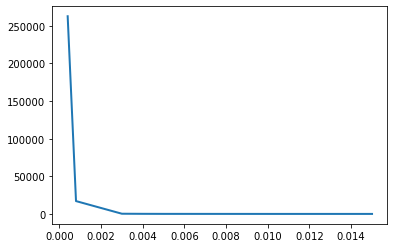

In [46]:
import matplotlib.pyplot as plt
plotar = [2,6,64,122,254,17050,262666]


fig, ax = plt.subplots()
ax.plot(support_levels, plotar, linewidth=2)
plt.show()

In [47]:
with plt.style.context('seaborn'):
    plt.xlabel('min_support'')
    plt.ylabel('quantidade de regras')
    plt.plot(support_levels, plotar, 'k--')
    plt.plot(support_levels, plotar, 'go')
    plt.title('Titulo')
    plt.show()

SyntaxError: EOL while scanning string literal (Temp/ipykernel_8860/1787554649.py, line 2)

"\ndata:dataframe - dataframe com variavel de venda e de item (CD_LANCAMENTO, CD_MATERIAL)\nalgorythm:module mlxtend.frequent_patterns - Algoritmo utilizado ('apriori', 'fpgrowth'), \nmin_supports:list - Lista com os min_supports >= 2 itens (0.015, 0.010, 0.05, ...),\nparameter:str - Parametro utilizado ('confidence, lift, leverage, conviction'), \nmin_threshold:list or int - Lista com os min_threshold, pode ser 1 valor só (0.9, 0.8, 0.7) or 0.5,\nplot:int - Imprime Gráfico unitário ou gráfico de comparação (0 = nao imprime grafico, 1 = unitario, 2 - comparacao)\n"

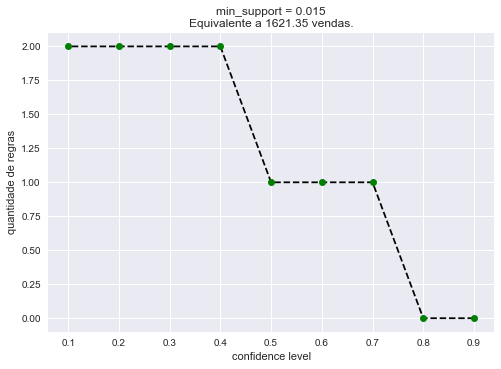

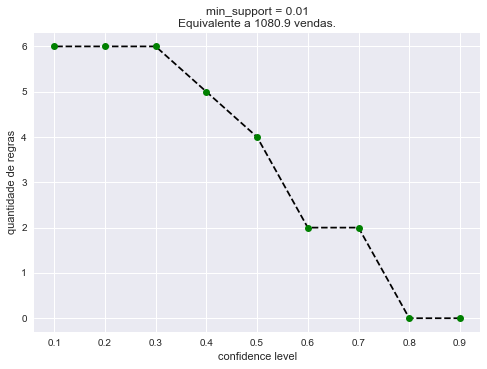

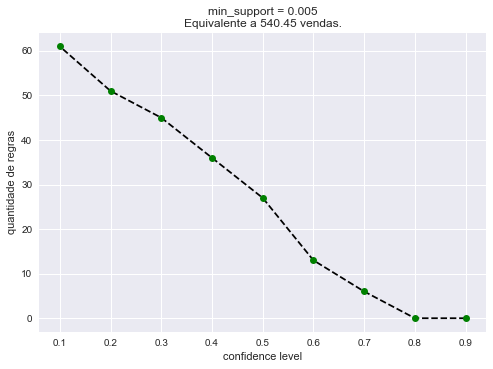

,min_support,confidence,qt_itemsets
0,0.015,0.9,0
1,0.015,0.8,0
2,0.015,0.7,1
3,0.015,0.6,1
4,0.015,0.5,1
5,0.015,0.4,2
6,0.015,0.3,2
7,0.015,0.2,2
8,0.015,0.1,2
9,0.010,0.9,0


In [ ]:
compare_association_rules(df, fpgrowth, [0.015,0.010,0.005], 'confidence', [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1], 1 )

0.0004625774817281895


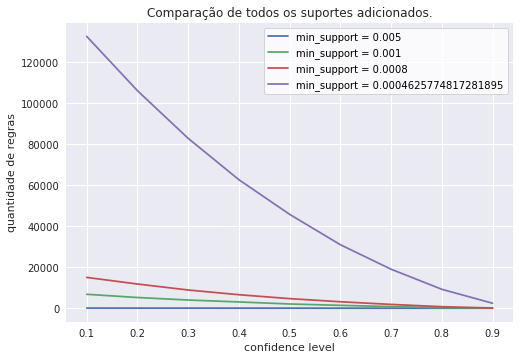

In [ ]:

#Definindo que uma quantidade de transações aceitaveis onde dois ou mais itens aconteçam,
#Teremos o min_support calculado, dividindo essa quantidade de transações pelo tamanho do df

qt_transact = 50
calc_support = qt_transact / len(df.index)
print(calc_support)
min_supports = [0.005, 0.001, 0.0008, calc_support]
min_threshold = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

teste = compare_association_rules(df, fpgrowth, min_supports, 'confidence', min_threshold, 2)

In [ ]:
df_eda = """
    SELECT
    T1.CD_PEDIDO,
    T2.CD_CLIENTE,
    T4.DS_CIDADE,
    T4.DS_UF,
    T1.CD_ITEM, 
    T1.CD_MATERIAL, 
    T1.DS_MATERIAL, 
    (CASE WHEN T5.DT_CADASTRO IS NULL THEN T2.DT_CADASTRO ELSE T5.DT_CADASTRO END) AS DT_CADASTRO,
    T2.DT_ATUALIZACAO, 
    T1.DS_UNIDADE, 
    T1.NR_QUANTIDADE, 
    T1.VL_UNITARIO, 
    T1.VL_TOTAL, 
    T1.CD_VENDEDOR
        FROM TBL_PEDIDOS_ITENS T1
            INNER JOIN TBL_PEDIDOS T2
            ON T1.CD_PEDIDO = T2.CD_PEDIDO
                INNER JOIN TBL_ENTIDADES T3
                ON T2.CD_CLIENTE = T3.CD_ENTIDADE
					INNER JOIN TBL_ENDERECO_CIDADES T4
					ON T3.CD_CIDADE = T4.CD_CIDADE
						LEFT JOIN TBL_ORCAMENTOS T5
						ON T5.CD_ORCAMENTO = T2.CD_ORCAMENTO
									WHERE T2.CD_FILIAL = 3
										AND T2.CD_STATUS = 4
											AND T2.DT_CADASTRO BETWEEN CONVERT(datetime, '2019-04-30T00:00:00.000') 
											AND CONVERT(datetime, '2022-04-30T00:00:00.000');
											
    """

In [2]:
df_eda = pd.read_csv('base_30042019_30042022.csv')

In [3]:
df_eda.DT_CADASTRO = pd.to_datetime(df_eda.DT_CADASTRO, format='%Y-%m-%d %H:%M:%S.%f')
df_eda.DT_ATUALIZACAO = pd.to_datetime(df_eda.DT_ATUALIZACAO, format='%Y-%m-%d %H:%M:%S.%f')

In [4]:
df_eda["TEMPO_PEDIDO"] = df_eda["DT_ATUALIZACAO"] - df_eda["DT_CADASTRO"]
df_eda.head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
0,272,532,ARAPIRACA,AL,3,727,PLASTUBOS JOELHO SOLD 90X25MM C/50,2019-05-03 10:45:39.953,2019-05-04 14:09:30,PC,400.0,0.17,68.0,1212,1 days 03:23:50.047000
1,272,532,ARAPIRACA,AL,4,857,PLASTUBOS TE SOLDAVEL 25 MM C/50,2019-05-03 10:45:39.953,2019-05-04 14:09:30,PC,100.0,0.31,31.0,1212,1 days 03:23:50.047000
2,272,532,ARAPIRACA,AL,5,1598,KRONA JOELHO 90 SOLD E ROSCA - 25MM X 1/2 C/30,2019-05-03 10:45:39.953,2019-05-04 14:09:30,UN,120.0,0.67,80.4,1212,1 days 03:23:50.047000
3,272,532,ARAPIRACA,AL,6,2220,KRONA TE SOLD E ROSCA (LR) 25MM X 1/2 C/20,2019-05-03 10:45:39.953,2019-05-04 14:09:30,UN,60.0,1.24,74.4,1212,1 days 03:23:50.047000
4,272,532,ARAPIRACA,AL,7,1659,KRONA LUVA SOLD E ROSCA ( LR) 25MM X 3/4 C/50,2019-05-03 10:45:39.953,2019-05-04 14:09:30,UN,50.0,0.48,24.0,1212,1 days 03:23:50.047000


In [5]:
df_eda.shape

(405479, 15)

In [6]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] > '0 days 10:00:00.000000'].index, inplace = True)
df_eda.shape

(358012, 15)

In [7]:
df_eda.head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
84,232,1391,MARAGOGI,AL,1,1355,HERC TORN JARDIM 1/2 C/ ADAPTADOR P/ 3/4 1128 ...,2019-05-03 09:49:09.900,2019-05-03 09:58:13,UN,60.0,1.79,107.40,8,0 days 00:09:03.100000
85,232,1391,MARAGOGI,AL,2,934,DECA PARAFUSO P/ BACIA LUXO/MEDIO CROMADO,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PC,1.0,16.82,16.82,8,0 days 00:09:03.100000
86,232,1391,MARAGOGI,AL,3,150,ATLAS ESPACADOR DE PISO DE 2MM C/100,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PCT,3.0,1.71,5.13,8,0 days 00:09:03.100000
87,232,1391,MARAGOGI,AL,4,151,ATLAS ESPACADOR DE PISO DE 3MM C/100,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PCT,2.0,1.71,3.42,8,0 days 00:09:03.100000
88,232,1391,MARAGOGI,AL,5,3,ACO CEARENSE ARAME REC 18 C/20 KG,2019-05-03 09:49:09.900,2019-05-03 09:58:13,KG,40.0,8.48,339.20,8,0 days 00:09:03.100000


In [8]:
df_eda['TEMPO_PEDIDO'].describe()

count                       358012
mean     0 days 00:17:52.960737754
std      0 days 01:00:11.792372714
min       -1 days +23:59:58.420000
25%                0 days 00:00:00
50%                0 days 00:00:00
75%         0 days 00:04:12.589000
max         0 days 09:59:22.030000
Name: TEMPO_PEDIDO, dtype: object

In [9]:
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
355015,102282,2575,ARAPIRACA,AL,2,709,TAF CAIXA P/ 06/08 DISJ BRANCO C/10 7057,2021-12-13 09:08:17.580,2021-12-13 09:08:16,PC,1.0,17.85,17.85,1232,-1 days +23:59:58.420000
355014,102282,2575,ARAPIRACA,AL,1,1957,"SIL CABO FLEXSIL 2,50 PRETO",2021-12-13 09:08:17.580,2021-12-13 09:08:16,PC,1.0,196.03,196.03,1232,-1 days +23:59:58.420000
266685,70324,2699,CORURIPE,AL,1,1195,TRAM PA DE BICO C/ CABO 71CM ECO 77459/434,2021-02-06 10:09:00.167,2021-02-06 10:08:59,UN,2.0,20.73,41.46,1233,-1 days +23:59:58.833000
266686,70324,2699,CORURIPE,AL,2,1198,TRAM PA QUADRADA C/ CABO 71CM ECO 77464/434,2021-02-06 10:09:00.167,2021-02-06 10:08:59,UN,2.0,20.73,41.46,1233,-1 days +23:59:58.833000
266687,70324,2699,CORURIPE,AL,3,1201,TRAM PICARETA CHIBANCA 4LB C/6 77305403,2021-02-06 10:09:00.167,2021-02-06 10:08:59,UN,4.0,35.51,142.04,1233,-1 days +23:59:58.833000


In [10]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] < '0 days 00:00:00.000000'].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
202340,52845,4014,SAO MIGUEL DOS MILAGRES,AL,19,1971,"SIL CABO SILFLEX PP 2 X 1,50 PRETO",2020-09-11 11:23:59.250,2020-09-11 11:23:59.250,PC,1.0,330.03,330.03,8,0 days
187689,48252,1176,ARAPIRACA,AL,2,1555,KRONA JOELHO 90 ESGOTO - 40MM C/50,2020-08-06 16:49:43.817,2020-08-06 16:49:43.817,UN,50.0,0.42,21.00,3535,0 days
187690,48252,1176,ARAPIRACA,AL,3,1639,KRONA LUVA SIMPLES ESG 40MM C/25,2020-08-06 16:49:43.817,2020-08-06 16:49:43.817,UN,25.0,0.47,11.75,3535,0 days
187691,48252,1176,ARAPIRACA,AL,4,2187,KRONA REDUCAO EXCEN ESGOTO 100X50MM C/10,2020-08-06 16:49:43.817,2020-08-06 16:49:43.817,UN,10.0,3.23,32.30,3535,0 days
187693,47877,646,UNIAO DOS PALMARES,AL,1,8,ACO CEARENSE BOBINA DE ZINCO 26 4 KG 100CM,2020-08-05 08:50:35.720,2020-08-05 08:50:35.720,KG,105.0,9.25,971.25,9,0 days


In [11]:
df_eda.drop(df_eda.loc[df_eda['DT_CADASTRO'] == df_eda['DT_ATUALIZACAO']].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
102795,27169,739,CARNEIROS,AL,1,3742,"COMPENSADO PARICA A 04MM (2,20MX1,60M)",2020-02-13 10:37:53.673,2020-02-13 10:37:53.677,CH,5.0,33.95,169.75,6,0 days 00:00:00.004000
102796,27169,739,CARNEIROS,AL,2,3743,"COMPENSADO PARICA A 10MM (2,20MX1,60M)",2020-02-13 10:37:53.673,2020-02-13 10:37:53.677,CH,10.0,62.30,623.00,6,0 days 00:00:00.004000
102798,27169,739,CARNEIROS,AL,4,3745,"COMPENSADO PARICA A 18MM (2,20MX1,60M)",2020-02-13 10:37:53.673,2020-02-13 10:37:53.677,CH,1.0,94.60,94.60,6,0 days 00:00:00.004000
102797,27169,739,CARNEIROS,AL,3,3744,"COMPENSADO PARICA A 15MM (2,20MX1,60M)",2020-02-13 10:37:53.673,2020-02-13 10:37:53.677,CH,10.0,82.90,829.00,6,0 days 00:00:00.004000
396448,114711,4142,SANTANA DO MUNDAU,AL,1,5337,JANELA CALHA COMERCIAL,2022-04-05 16:23:10.177,2022-04-05 16:23:10.193,UN,10.0,57.25,572.50,9,0 days 00:00:00.016000


In [12]:
df_eda.drop(df_eda.loc[df_eda['TEMPO_PEDIDO'] < '0 days 00:00:10.000000'].index, inplace = True)
df_eda.sort_values(by=['TEMPO_PEDIDO'], ascending = True).head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO
86030,23097,806,MACEIO,AL,2,4046,ADUELA DE MASSARANDUBA,2020-01-04 11:56:46.997,2020-01-04 11:56:57,JG,20.0,66.95,1339.0,84,0 days 00:00:10.003000
86029,23097,806,MACEIO,AL,1,3694,ADUELA MISTA,2020-01-04 11:56:46.997,2020-01-04 11:56:57,JG,20.0,43.80,876.0,84,0 days 00:00:10.003000
187670,46235,1547,CAJUEIRO,AL,1,3694,ADUELA MISTA,2020-07-23 13:45:18.987,2020-07-23 13:45:29,JG,40.0,43.80,1752.0,1212,0 days 00:00:10.013000
351440,98672,3170,ARAPIRACA,AL,1,5031,NITROLUX LAMP LED BULBO 14W BIV 6500K C/10 3158,2021-11-19 11:25:32.933,2021-11-19 11:25:43,UN,2.0,12.10,24.2,1233,0 days 00:00:10.067000
383709,109961,6042,ARAPIRACA,AL,1,2168,KRONA LUVA SOLDAVEL - 25MM C/50 0436,2022-02-22 08:52:24.853,2022-02-22 08:52:35,UN,50.0,0.48,24.0,1212,0 days 00:00:10.147000


In [13]:
df_eda.shape

(127215, 15)

In [14]:
df_eda['TEMPO_PEDIDO'].describe(percentiles = [.01, .05,.25, .5, .75, .95, .99])

count                       127215
mean     0 days 00:50:19.837205541
std      0 days 01:32:32.685358847
min         0 days 00:00:10.003000
1%          0 days 00:00:20.963980
5%          0 days 00:00:44.214900
25%         0 days 00:03:20.173000
50%         0 days 00:11:03.550000
75%         0 days 00:44:36.026500
95%         0 days 04:36:01.607000
99%         0 days 07:13:21.503000
max         0 days 09:59:22.030000
Name: TEMPO_PEDIDO, dtype: object

In [15]:
df_eda["DATA_PEDIDO"] = df_eda["DT_CADASTRO"].dt.date
df_eda.head()

,CD_PEDIDO,CD_CLIENTE,DS_CIDADE,DS_UF,CD_ITEM,CD_MATERIAL,DS_MATERIAL,DT_CADASTRO,DT_ATUALIZACAO,DS_UNIDADE,NR_QUANTIDADE,VL_UNITARIO,VL_TOTAL,CD_VENDEDOR,TEMPO_PEDIDO,DATA_PEDIDO
84,232,1391,MARAGOGI,AL,1,1355,HERC TORN JARDIM 1/2 C/ ADAPTADOR P/ 3/4 1128 ...,2019-05-03 09:49:09.900,2019-05-03 09:58:13,UN,60.0,1.79,107.40,8,0 days 00:09:03.100000,2019-05-03
85,232,1391,MARAGOGI,AL,2,934,DECA PARAFUSO P/ BACIA LUXO/MEDIO CROMADO,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PC,1.0,16.82,16.82,8,0 days 00:09:03.100000,2019-05-03
86,232,1391,MARAGOGI,AL,3,150,ATLAS ESPACADOR DE PISO DE 2MM C/100,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PCT,3.0,1.71,5.13,8,0 days 00:09:03.100000,2019-05-03
87,232,1391,MARAGOGI,AL,4,151,ATLAS ESPACADOR DE PISO DE 3MM C/100,2019-05-03 09:49:09.900,2019-05-03 09:58:13,PCT,2.0,1.71,3.42,8,0 days 00:09:03.100000,2019-05-03
88,232,1391,MARAGOGI,AL,5,3,ACO CEARENSE ARAME REC 18 C/20 KG,2019-05-03 09:49:09.900,2019-05-03 09:58:13,KG,40.0,8.48,339.20,8,0 days 00:09:03.100000,2019-05-03


In [16]:
df1 = df_eda

In [17]:
df1.drop(columns=['DS_CIDADE','DS_UF','CD_ITEM','CD_MATERIAL','DS_MATERIAL','DT_CADASTRO','DT_ATUALIZACAO','DS_UNIDADE','NR_QUANTIDADE','VL_UNITARIO','VL_TOTAL','CD_VENDEDOR','TEMPO_PEDIDO'], inplace=True)

In [18]:
df1.head(15)

,CD_PEDIDO,CD_CLIENTE,DATA_PEDIDO
84,232,1391,2019-05-03
85,232,1391,2019-05-03
86,232,1391,2019-05-03
87,232,1391,2019-05-03
88,232,1391,2019-05-03
89,232,1391,2019-05-03
90,232,1391,2019-05-03
91,232,1391,2019-05-03
92,232,1391,2019-05-03
93,232,1391,2019-05-03


In [19]:
df1.shape

(127215, 3)

In [20]:
df1 = df1.drop_duplicates()
df1.head(10)

,CD_PEDIDO,CD_CLIENTE,DATA_PEDIDO
84,232,1391,2019-05-03
127,36,1581,2019-05-02
250,432,930,2019-05-06
287,520,490,2019-05-07
293,1013,1491,2019-05-13
308,368,542,2019-05-04
333,786,2119,2019-05-09
340,41,1577,2019-05-02
370,88,855,2019-05-02
373,91,1508,2019-05-02


In [21]:
df1.shape

(42349, 3)

In [22]:
df_7168 = df1.loc[df1['CD_CLIENTE'] == 7168].sort_values(by='DATA_PEDIDO', ascending=False)

In [23]:
df_7168.head()

,CD_PEDIDO,CD_CLIENTE,DATA_PEDIDO
404180,157412,7168,2022-04-26
403014,151490,7168,2022-04-25
395161,121183,7168,2022-04-13
398620,116162,7168,2022-04-07
389834,113542,7168,2022-03-25


In [24]:
df_7168_2 = df_7168.groupby(['CD_CLIENTE', 'DATA_PEDIDO']
                          ).size().reset_index(name="QT")

In [25]:
df_7168_2.drop(df_7168_2.loc[df_7168_2['QT'] == 1].index, inplace = True)

In [26]:
df_7168_2

,CD_CLIENTE,DATA_PEDIDO,QT
6,7168,2021-09-23,2
8,7168,2021-09-30,2
9,7168,2021-10-13,2
12,7168,2021-11-03,2
16,7168,2021-11-29,2
19,7168,2021-12-09,2
21,7168,2021-12-14,2
24,7168,2022-01-03,3
26,7168,2022-01-10,2
31,7168,2022-02-01,2


In [27]:
df3 = df1.groupby(['CD_CLIENTE', 'DATA_PEDIDO']
                          ).size().reset_index(name="QT")
df3.head()

,CD_CLIENTE,DATA_PEDIDO,QT
0,6,2019-06-21,1
1,6,2019-09-26,1
2,6,2019-11-20,1
3,6,2019-11-22,1
4,6,2019-11-28,1


In [28]:
df3.shape

(34193, 3)

In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34193 entries, 0 to 34192
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CD_CLIENTE   34193 non-null  int64 
 1   DATA_PEDIDO  34193 non-null  object
 2   QT           34193 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 801.5+ KB


In [30]:
df3.drop(df3.loc[df3['QT'] == 1].index, inplace = True)
df3.shape

(5686, 3)

In [31]:
df3.head()

,CD_CLIENTE,DATA_PEDIDO,QT
32,8,2020-01-08,2
58,10,2019-08-02,3
60,10,2019-09-13,3
78,10,2021-01-19,2
99,10,2022-02-15,2


In [32]:
df3 = df3.sort_values(by='DATA_PEDIDO', ascending=False)
df3.head(10)

,CD_CLIENTE,DATA_PEDIDO,QT
11712,2080,2022-04-29,4
33278,7432,2022-04-29,2
33103,7285,2022-04-29,2
31456,6297,2022-04-29,2
1389,512,2022-04-28,2
1527,527,2022-04-28,2
25264,4046,2022-04-28,2
23296,3478,2022-04-28,2
25415,4126,2022-04-28,2
6259,1641,2022-04-27,2


In [35]:
df3 = df3.sort_values(by='DATA_PEDIDO', ascending=False)
df3.head(100)

,CD_CLIENTE,DATA_PEDIDO,QT
33103,7285,2022-04-29,2
33278,7432,2022-04-29,2
31456,6297,2022-04-29,2
11712,2080,2022-04-29,4
25415,4126,2022-04-28,2
1527,527,2022-04-28,2
23296,3478,2022-04-28,2
25264,4046,2022-04-28,2
1389,512,2022-04-28,2
14735,2200,2022-04-27,2


In [117]:
df3['QT'].describe(percentiles = [.01, .05,.25, .5, .75, .95, .99])

count    5686.000000
mean        2.434400
std         1.000003
min         2.000000
1%          2.000000
5%          2.000000
25%         2.000000
50%         2.000000
75%         2.000000
95%         4.000000
99%         7.000000
max        11.000000
Name: QT, dtype: float64

In [118]:
df_total = df1.groupby(['CD_CLIENTE', 'DATA_PEDIDO']
                          ).size().reset_index(name="QT")

In [124]:
df_total['QT'].describe()

count    34193.000000
mean         1.238528
std          0.671957
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: QT, dtype: float64

In [120]:
df_total.shape

(34193, 3)

In [121]:
df3.shape

(5686, 3)

In [122]:
df3.describe()

,CD_CLIENTE,QT
count,5686.000000,5686.000000
mean,2746.503517,2.434400
std,1700.929783,1.000003
min,8.000000,2.000000
25%,1895.000000,2.000000
50%,2118.000000,2.000000
75%,3444.000000,2.000000
max,8434.000000,11.000000


In [149]:
df3

,CD_CLIENTE,DATA_PEDIDO,QT
33278,7432,2022-04-29,2
31456,6297,2022-04-29,2
11712,2080,2022-04-29,4
33103,7285,2022-04-29,2
1527,527,2022-04-28,2
25264,4046,2022-04-28,2
1389,512,2022-04-28,2
23296,3478,2022-04-28,2
25415,4126,2022-04-28,2
22794,3395,2022-04-27,2


In [153]:
df3.loc[df3['DATA_PEDIDO']>2022-4-1]

TypeError: '>' not supported between instances of 'datetime.date' and 'int'

In [154]:
df3.head()

,CD_CLIENTE,DATA_PEDIDO,QT
33278,7432,2022-04-29,2
31456,6297,2022-04-29,2
11712,2080,2022-04-29,4
33103,7285,2022-04-29,2
1527,527,2022-04-28,2


In [157]:
df3.to_csv('cliente_dia.csv', index=False)